In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

## Preprocessing

In [255]:
def addHour(row):
    if row[-3] == 'EST':
        row[0] = row[0] + pd.to_timedelta(1, unit='h')
        row[-3] = 'EDT'
    return row

In [256]:
dataRaw = pd.read_csv('waterLevel.txt', skiprows = np.arange(29), delimiter = '	', names = ['USGS', 'code', 'time', 'timeZone', 'heightFeet', 'provisional']) 
dataRaw = dataRaw.drop(['USGS', 'code'], axis = 1)
dataRaw['time'] = pd.to_datetime(dataRaw['time'])
dataRaw = dataRaw.apply(addHour, axis = 1)

## Speed analysis

Text(0, 0.5, 'Number of occurence')

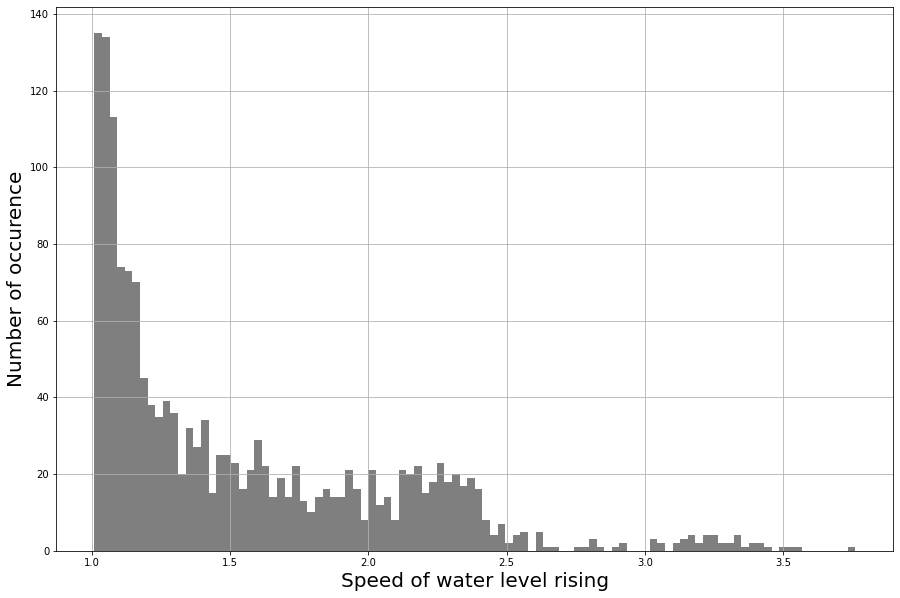

In [364]:
dataDiff = pd.DataFrame(dataRaw['heightFeet'].diff()).rename(columns = {'heightFeet': 'heightDiff'})
dataDiff['heightDiffPositive'] = dataDiff[dataDiff > 1]
dataDiff['movingAve'] = dataDiff['heightDiff'].rolling(2).mean()
dataDiff['movingAvePositive'] = dataDiff['movingAve'][dataDiff['movingAve'] > 0]
dataDiff['index'] = np.arange(dataDiff.shape[0])

#dataDiff.plot.scatter(x="index", y="heightDiffPositive")
plt.figure(figsize=(15,10))
dataDiff['heightDiffPositive'].hist(color="k", alpha=0.5, bins=100)
plt.xlabel('Speed of water level rising', fontsize=20)
plt.ylabel('Number of occurence', fontsize=20)

## Water level analysis (Fourier transform and nosie reduction)

(0.0, 700.0)

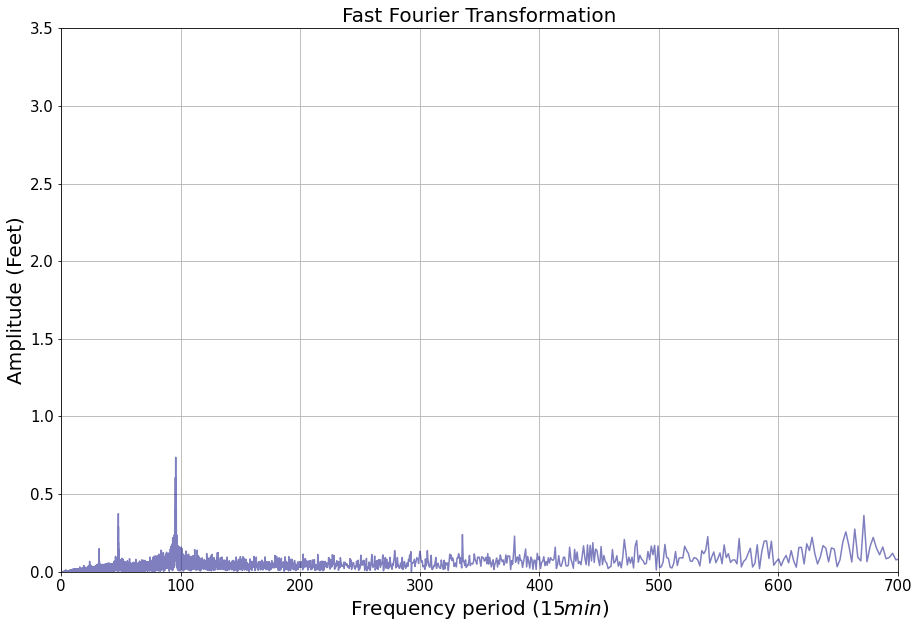

In [403]:
height = np.array(dataRaw.heightFeet)
time = dataRaw.time

fft =np.fft.fft(height)
newN=int(len(fft)/2) 
fNat=1
newX = np.linspace(10**-12, fNat/2, newN, endpoint=True)
newXph = 1.0/(newX)
fftAbs = np.abs(fft)

plt.figure(figsize=(15,10))
plt.plot(newXph, 2 * fftAbs[0: int(len(fft) / 2.)] / len(newXph), color='navy',alpha=0.5)
plt.xlabel('Frequency period ($15 min$)',fontsize=20)
plt.ylabel('Amplitude (Feet)',fontsize=20)
plt.title('Fast Fourier Transformation', fontsize=20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(True)
plt.ylim(0,3.5)
#plt.xlim(0,175270)
plt.xlim(0,700)

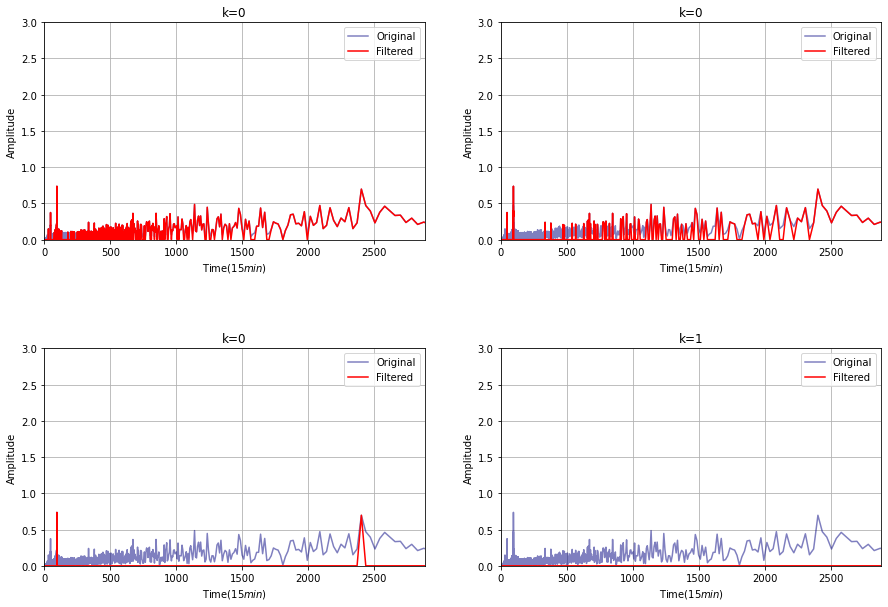

In [369]:
#Defining the filtering function
def fft_filter(th):
    fft_tof=fft.copy()
    fft_tof_abs=np.abs(fft_tof)
    fft_tof_abs=2*fft_tof_abs/len(newXph)
    fft_tof[fft_tof_abs<=th]=0
    return fft_tof

#Showing the plots at different thresholds values
#Defining the amplitude filtering function
def fft_filter_amp(th):
    fft_tof=fft.copy()
    fft_tof_abs=np.abs(fft_tof)
    fft_tof_abs=2*fft_tof_abs/len(newXph)
    fft_tof_abs[fft_tof_abs<=th]=0
    return fft_tof_abs[0:int(len(fft_tof_abs)/2.)]

K_plot=[0.1,0.2,0.5,1]
j=0
plt.figure(figsize=(15,10))
for k in K_plot:
    j=j+1
    plt.subplot(2,2,j)
    plt.title('k=%i'%(k))
    plt.xlim(0,2880)
    plt.ylim(0,3)
    plt.plot(newXph,2*fftAbs[0:int(len(fft)/2.)]/len(newXph),color='navy',alpha=0.5,label='Original')
    plt.grid(True)
    plt.plot(newXph,fft_filter_amp(k),'red',label='Filtered')
    plt.xlabel('Time($15min$)')
    plt.ylabel('Amplitude')
    plt.legend()
plt.subplots_adjust(hspace=0.5)

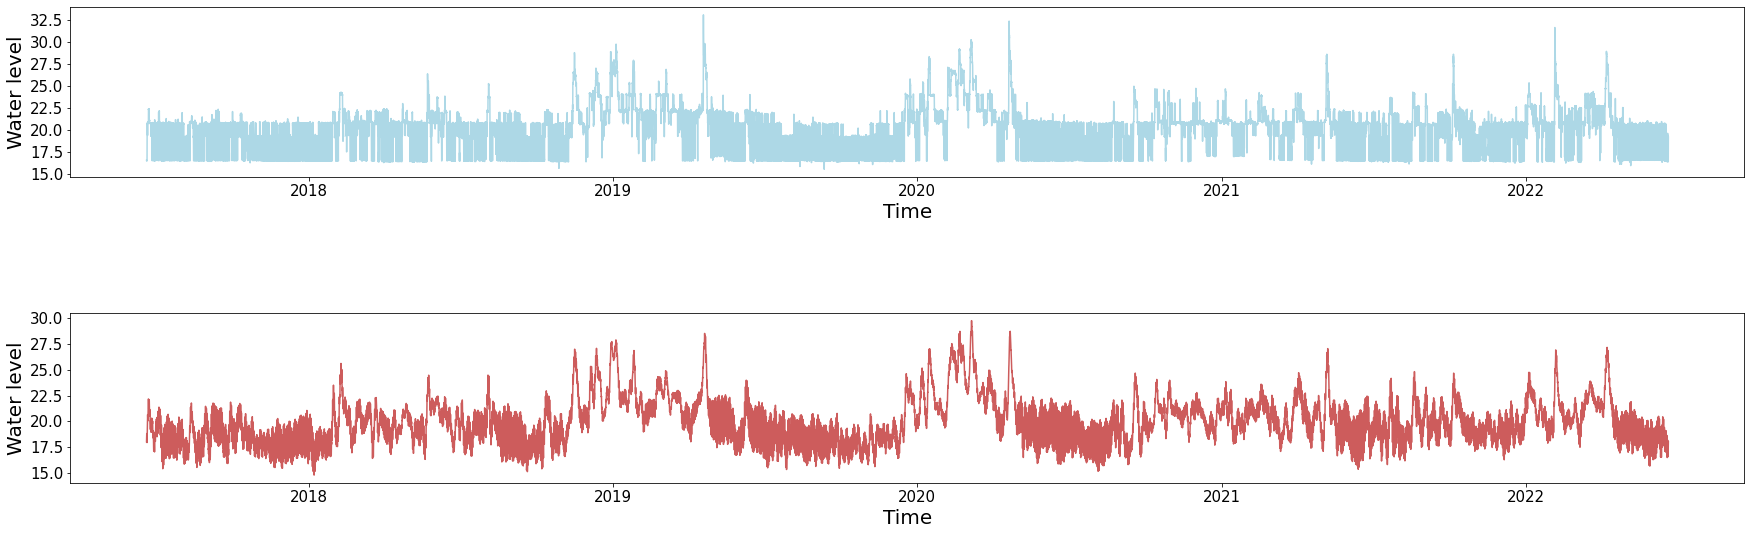

In [406]:
def fft_filter(perc):
    th=perc*(2*fftAbs[0:int(len(fft)/2.)]/len(newXph)).max()
    fft_tof=fft.copy()
    fft_tof_abs=np.abs(fft_tof)
    fft_tof_abs=2*fft_tof_abs/len(newXph)
    fft_tof[fft_tof_abs<=th]=0
    return fft_tof

#Showing some plots at different threshold values
colors = ['b', 'lightblue', 'indianred', 'mediumseagreen', 'y']
K_plot_values=[0.0,0.00175]
j=0
plt.figure(figsize=(30,20))
for k in K_plot_values:
    j+=1
    plt.subplot(4,1,j)
    plt.plot(time,np.fft.ifft(fft_filter(k)),color=colors[j])
    plt.xlabel('Time', fontsize = 20)
    plt.ylabel('Water level', fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
plt.subplots_adjust(hspace=0.8)